In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

### 1 Einlesen der bereinigten Daten

In [2]:
df_slurm = pd.read_csv("tweaked_datasets/slurm_dataset_tweaked.csv", index_col=0)
df_slurm.head()

,Account,AllocCPUS,AllocNodes,ElapsedRaw,ExitCode,Flags,Priority,Partition,QOSRAW,ReqCPUS,ReqNodes,ResvCPURAW,Start,TimelimitRaw,User,ReqBilling,ReqMem_in_MB,Reserved_in_s,AllocMem_in_MB
0,94f78603-6e51-40ca-99c6-b494ac1ee324,768,32,35,0:0,SchedBackfill,4294901759,regular,1,384,32,0,2020-01-31 16:01:26,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,384.0,7900.0,0,6067200.0
1,94f78603-6e51-40ca-99c6-b494ac1ee324,384,16,167,other,SchedMain,4294901758,regular,1,192,16,192,2020-01-31 16:02:42,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,192.0,7900.0,1,3033600.0
2,94f78603-6e51-40ca-99c6-b494ac1ee324,384,16,25,0:0,SchedMain,4294901757,regular,1,192,16,192,2020-01-31 16:05:04,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,192.0,7900.0,1,3033600.0
3,94f78603-6e51-40ca-99c6-b494ac1ee324,192,8,19,0:0,SchedMain,4294901756,regular,1,96,8,96,2020-01-31 16:05:50,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,96.0,7900.0,1,1516800.0
4,ee18ced8-5c8f-4b12-a606-6b282105d967,24,1,236,0:0,SchedSubmit,4294901755,regular,1,1,1,0,2020-01-31 16:28:49,1440.0,eed47b6a-a483-4194-85a6-8ae0f6ca5adb,1.0,7900.0,0,189600.0


Da das Datetime Objekt durch das speichern in einer csv verloren geht, wird dies hier erneut zugeordnet:

In [3]:
df_slurm.Start = pd.to_datetime(df_slurm.Start, yearfirst=True)

Der Einfachheit halber, werden die pseduonymisierten Accountnamen zu einer ID im integer Format umbenannt.

In [4]:
unique_acc = df_slurm["Account"].unique()
acc_replace_dict = {acc:i for i, acc in enumerate(unique_acc)}
df_slurm["Account"] = df_slurm.Account.map(acc_replace_dict)
df_slurm.head()

,Account,AllocCPUS,AllocNodes,ElapsedRaw,ExitCode,Flags,Priority,Partition,QOSRAW,ReqCPUS,ReqNodes,ResvCPURAW,Start,TimelimitRaw,User,ReqBilling,ReqMem_in_MB,Reserved_in_s,AllocMem_in_MB
0,0,768,32,35,0:0,SchedBackfill,4294901759,regular,1,384,32,0,2020-01-31 16:01:26,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,384.0,7900.0,0,6067200.0
1,0,384,16,167,other,SchedMain,4294901758,regular,1,192,16,192,2020-01-31 16:02:42,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,192.0,7900.0,1,3033600.0
2,0,384,16,25,0:0,SchedMain,4294901757,regular,1,192,16,192,2020-01-31 16:05:04,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,192.0,7900.0,1,3033600.0
3,0,192,8,19,0:0,SchedMain,4294901756,regular,1,96,8,96,2020-01-31 16:05:50,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,96.0,7900.0,1,1516800.0
4,1,24,1,236,0:0,SchedSubmit,4294901755,regular,1,1,1,0,2020-01-31 16:28:49,1440.0,eed47b6a-a483-4194-85a6-8ae0f6ca5adb,1.0,7900.0,0,189600.0


### 2.1 Average elapsed time per Account & Average difference requested vs. elapsed time per Account

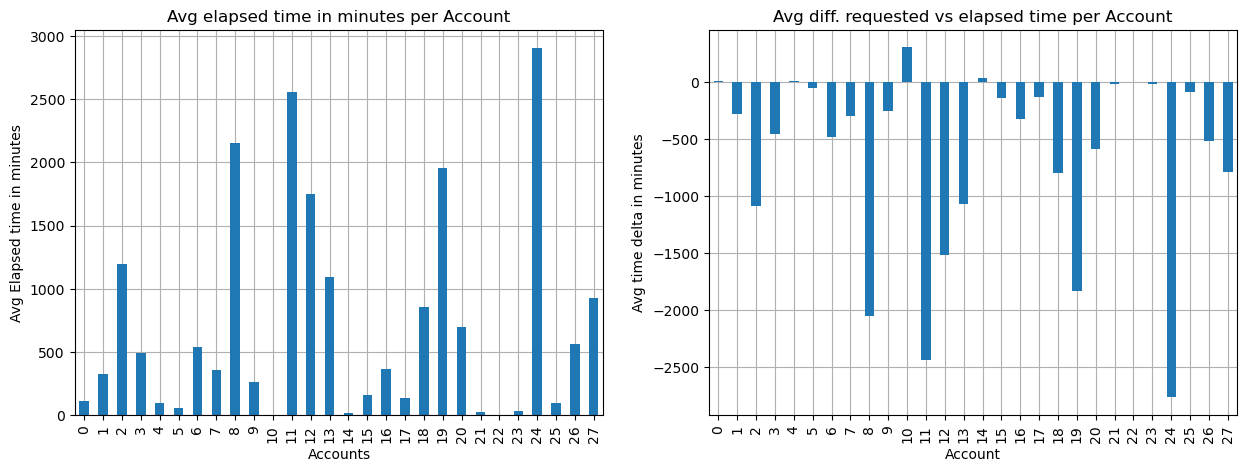

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

(df_slurm
    .assign(ElapsedMinutes = df_slurm["ElapsedRaw"]/60)
    .groupby(["Account"])
    .ElapsedMinutes
    .mean()
    .plot(kind="bar", xlabel="Accounts", ylabel="Avg Elapsed time in minutes", title="Avg elapsed time in minutes per Account", ax=ax1, grid=True, zorder = 2))

(df_slurm
    .assign(timedelta=(df_slurm["TimelimitRaw"]/60) - (df_slurm["ElapsedRaw"]/60))
    .groupby(["Account"])
    .timedelta
    .mean()
    .plot(kind="bar", xlabel="Account", ylabel="Avg time delta in minutes", title="Avg diff. requested vs elapsed time per Account", ax=ax2, grid=True, zorder=2))
plt.show()

Die Accounts 2,8,11,12,13,19 und 24 haben im Vergleich zu den restlichen Accounts eine deutlich höhere Rechenzeit, als alle Anderen Accounts(Avg. elapsed time >1000min).
Außerdem sind diese zugleich auch die Accounts, denen die meiste Rechenzeit ermöglicht wurde. Allerdings sind diese im Verhältnis zu den anderen Accounts auch die, die die Rechenzeit am wenigsten ausgereizt haben. Nur wenige Accounts haben es im Schnitt geschafft, ihre Rechenzeit im Schnitt zu überschreiten. Besonders auffällig ist dort Account 10.

### 2.2 Average Requested CPUs per Account & Avg.diff. allocated vs. requested CPUs per Account

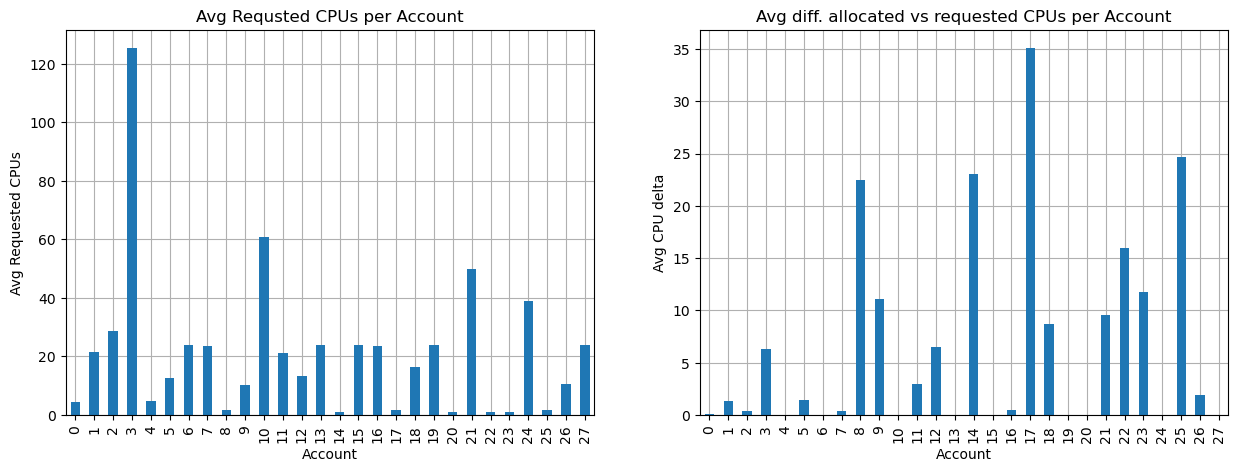

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

(df_slurm.groupby(["Account"])
    .ReqCPUS
    .mean()
    .plot(kind="bar", xlabel="Account", ylabel="Avg Requested CPUs", title="Avg Requsted CPUs per Account", ax=ax1, grid=True, zorder = 2))

(df_slurm
    .assign(cpudelta=df_slurm["AllocCPUS"] - df_slurm["ReqCPUS"])
    .groupby(["Account"])
    .cpudelta
    .mean()
    .plot(kind="bar", xlabel="Account", ylabel="Avg CPU delta", title="Avg diff. allocated vs requested CPUs per Account", ax=ax2, grid=True, zorder=2))

plt.show()

Die Accounts 3, 10 und 21 sind die mit dem im Schnitt am meisten angefragten CPUs. Account 8, 14, 17 und 25 hatten im Schnitt die wenigsten CPUs gebraucht, die sie angefragt haben.

### 2.3 Average Priority per User

Diese Beobachtung mag vielleicht am Anfang sinnlos erscheinen, jedoch ist dadurch erkennbar, welche User insgesamt die höchste Priorität für ihre Tasks besitzen.

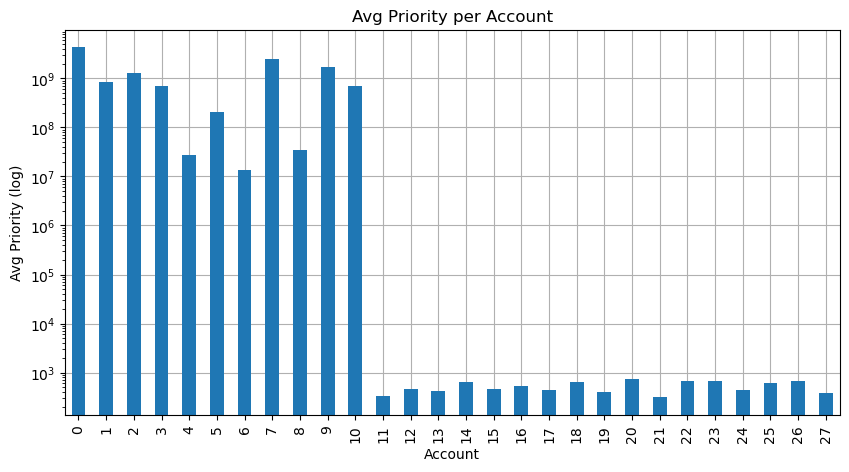

In [24]:
fig, ax = plt.subplots(figsize=(10,5))

(df_slurm.groupby(["Account"])
    .Priority
    .mean()
    .plot(kind="bar", xlabel="Account", ylabel="Avg Priority (log)", title="Avg Priority per Account", ax=ax, grid=True, zorder = 2, logy=True))

plt.show()

Die Accounts 0-10 haben im Schnitt eine erheblich höhere Priority als die restlichen Accounts.

### 2.4 Tasks per time

In [8]:
def tasks_per_time(timedelta, timelabel, title):
    '''
    Plottet die Anzahl an Tasks pro Zeiteinheit(timedelta)
    timedelta: Zeiteinheit (z.B. nach Wochentage, Monat, etc.)
    timelabel: xlabel für Plot
    title: Titel des Plots
    '''

    fig, ax = plt.subplots(figsize=(10,5))

    (df_slurm.groupby([timedelta])
        .Account
        .count()
        .plot(kind="bar", xlabel=timelabel, ylabel="count", title=title, ax=ax, grid=True, zorder = 2))
    ax.axhline(y=df_slurm.groupby([timedelta]).Account.count().mean(), color="red")

#### 2.4.1 Tasks per day of week

In [9]:
df_slurm["Start_day_of_week"] = df_slurm.Start.dt.weekday
df_slurm["Start_hour_of_day"] = df_slurm.Start.dt.hour
df_slurm["Start_month"] = df_slurm.Start.dt.month

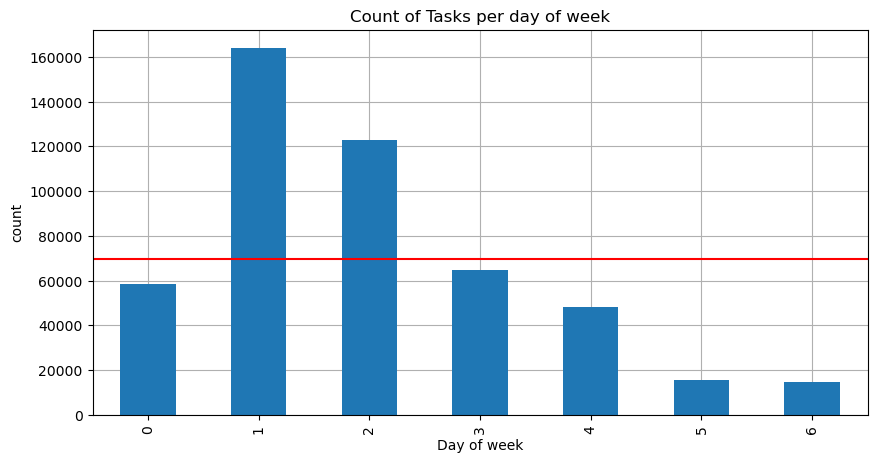

In [10]:
tasks_per_time("Start_day_of_week", "Day of week", "Count of Tasks per day of week")

Interessanterweise, sind Dienstag und Mittwoch die Tage mit den meisten Tasks. Wie zu erwarten, sind Samstag und Sonntag die Tage mit den wenigsten Tasks.

#### 2.4.2  Tasks per hour of day

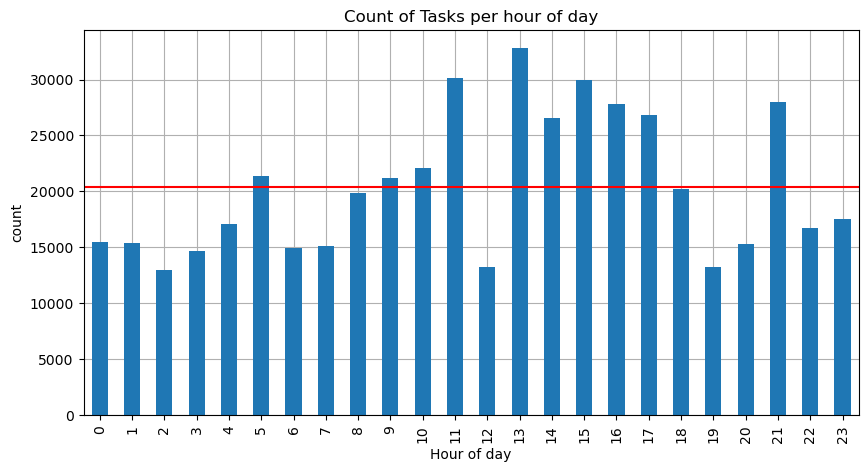

In [11]:
tasks_per_time("Start_hour_of_day", "Hour of day", "Count of Tasks per hour of day")

Auffällig ist der erheblich niedrigere Count, um 12:00Uhr. Außerdem fällt noch auf, dass im Verhältnis zu naheliegenden Uhrzeiten, 5:00Uhr und 21:00Uhr erhöhte Counts haben. 

#### 2.4.3 Tasks per month

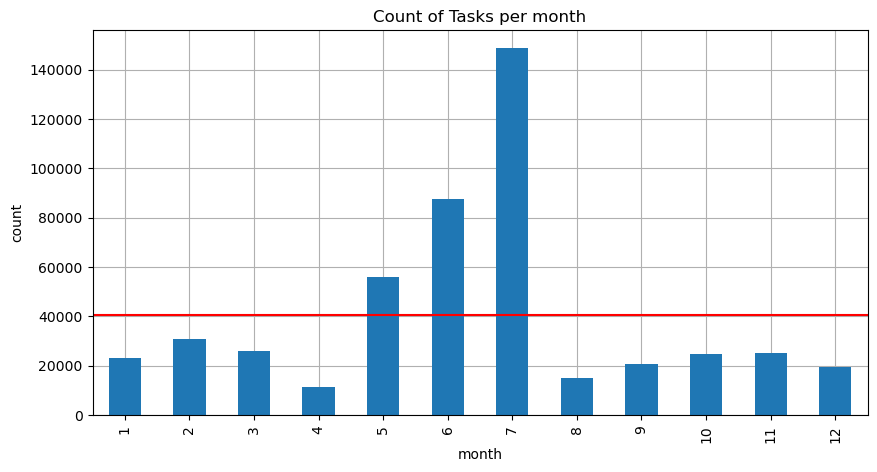

In [12]:
tasks_per_time("Start_month", "month", "Count of Tasks per month")

Klar auffällig sind hier die überdurchschnittlich hohen Counts im Monat Mai, Juni und Juli.

### 2.5 Feature Count

In [13]:
def feature_count(feature, title):
    '''
    Plottet den Count der Tasks pro Attributs eines Features
    feature: Zu übergebenes Feature des DataFrames (z.B. ExitCode)
    title: Titel des Plots
    '''

    fig, ax = plt.subplots(figsize=(10,5))

    (df_slurm.groupby([feature])
        .Account
        .count()
        .plot(kind="bar", xlabel=feature, ylabel="count", title=title, ax=ax, grid=True, zorder = 2))

#### 2.5.1 ExitCode Count

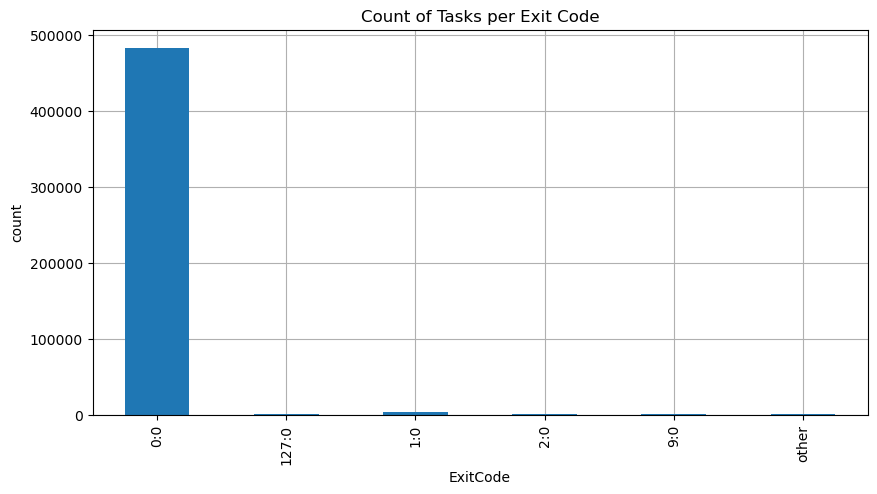

In [14]:
feature_count("ExitCode", "Count of Tasks per Exit Code")

Der ExitCode 0:0 wird hier ganz klar am meisten ausgewertet.

#### 2.5.2 Flags Count

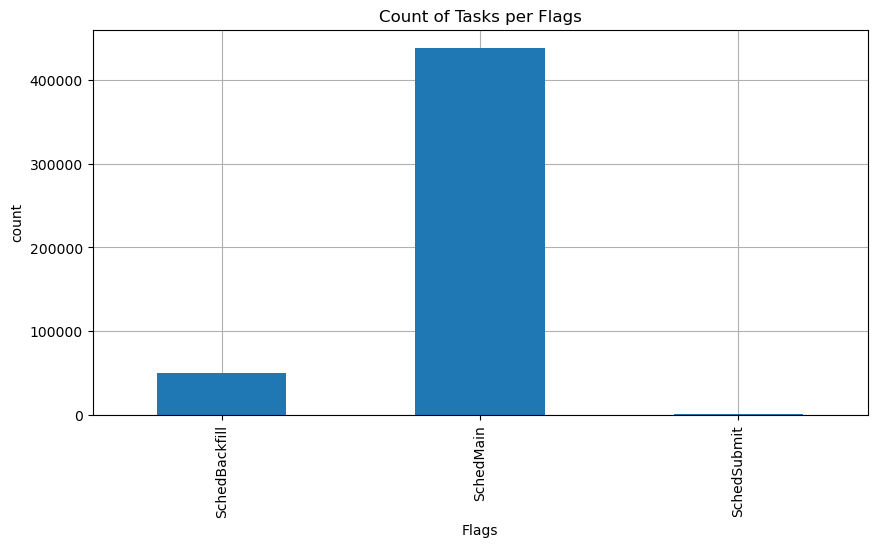

In [15]:
feature_count("Flags", "Count of Tasks per Flags")

Hier tritt ganz klar die Flag 'SchedMain' am Häufigsten auf.

### 2.6 CPU cores per hour

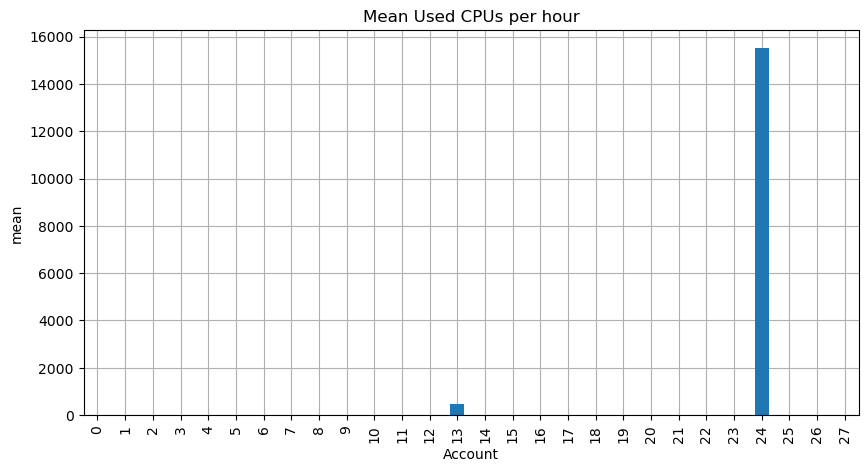

In [25]:
fig, ax = plt.subplots(figsize=(10,5))

(df_slurm
    .assign(Corehours = df_slurm["ReqCPUS"] / (df_slurm["ElapsedRaw"]/3600))
    .groupby(["Account"])
    .Corehours
    .mean()
    .plot(kind="bar", xlabel="Account", ylabel="mean", title="Mean Used CPUs per hour", ax=ax, grid=True, zorder = 2))

plt.show()

Es fällt sehr stark auf, dass Account 13 und 24 mit Abstand die meisten CPU hours haben und somit wahrscheinlich die rechenintensivsten Tasks hatten.

### 2.7 Finished/Cancelled ratio of Tasks per Account

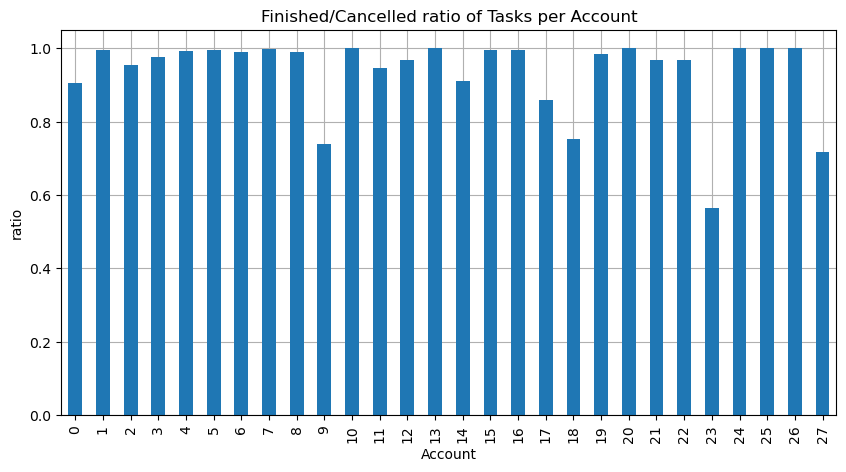

In [26]:
fig, ax = plt.subplots(figsize=(10,5))

((df_slurm.query("ExitCode == '0:0'").groupby(["Account"]).Account.count() / df_slurm.groupby("Account").Account.count())
    .plot(kind="bar", xlabel="Account", ylabel="ratio", title="Finished/Cancelled ratio of Tasks per Account", ax=ax, grid=True, zorder = 2))

plt.show()

Hier sind keine große Besonderheiten zu nennen. Account 9, 18, 23 und 27 haben allerdings im Schnitt eine Finished/Cancelled ratio von unter 80%.

### 3 Entfernung der Start Spalte

Aufgrund der zu hohen Komplexität für das Clustering, wird das Datetime Objekt entfernt und lediglich die Stunde und der Wochentag beibehalten.

In [18]:
df_slurm.drop("Start", axis=1, inplace=True)

In [19]:
df_slurm.to_csv("tweaked_datasets/slurm_dataset_tweaked.csv")

In [20]:
df_slurm.head()

,Account,AllocCPUS,AllocNodes,ElapsedRaw,ExitCode,Flags,Priority,Partition,QOSRAW,ReqCPUS,...,ResvCPURAW,TimelimitRaw,User,ReqBilling,ReqMem_in_MB,Reserved_in_s,AllocMem_in_MB,Start_day_of_week,Start_hour_of_day,Start_month
0,0,768,32,35,0:0,SchedBackfill,4294901759,regular,1,384,...,0,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,384.0,7900.0,0,6067200.0,4,16,1
1,0,384,16,167,other,SchedMain,4294901758,regular,1,192,...,192,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,192.0,7900.0,1,3033600.0,4,16,1
2,0,384,16,25,0:0,SchedMain,4294901757,regular,1,192,...,192,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,192.0,7900.0,1,3033600.0,4,16,1
3,0,192,8,19,0:0,SchedMain,4294901756,regular,1,96,...,96,7200.0,1f847aac-d8bf-40ea-b747-405efe2ce745,96.0,7900.0,1,1516800.0,4,16,1
4,1,24,1,236,0:0,SchedSubmit,4294901755,regular,1,1,...,0,1440.0,eed47b6a-a483-4194-85a6-8ae0f6ca5adb,1.0,7900.0,0,189600.0,4,16,1
